In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np

import scipy.optimize as optimization
from scipy.optimize import least_squares

In [38]:
#C:\ti\simplelink_cc13x2_26x2_sdk_4_40_04_04\tools\ble5stack\rtls_agent\examples\3ANT\ofoghi\rtls_aoa_iq_with_rtls_util_export_into_csv_3ant_AoA_log\04_16_2021_16_55_55_rtls_raw_iq_samples_0x11_zero_f88a5e2d7808_0.csv
# path = 'C:/ti/simplelink_cc13x2_26x2_sdk_4_40_04_04/tools/ble5stack/rtls_agent/examples/3ANT/ofoghi/rtls_aoa_iq_with_rtls_util_export_into_csv_3ant_AoA_log/04_16_2021_16_55_55_rtls_raw_iq_samples_0x11_zero_f88a5e2d7808_0.csv' # test @ 1m 
path = 'C:/Users/pooneh/Documents/GitHub/AoA_IQsamples/AoA/DoA_Final/3_ANT/3ANT_AoA/datapoints_250cm/3ANT/zero_degree_zero_posi/05_18_2021_14_27_33_rtls_raw_iq_samples_f88a5e2d7808_0.csv'
path2 = 'C:/Users/pooneh/Documents/GitHub/AoA_IQsamples/AoA/DoA_Final/3_ANT/3ANT_AoA/datapoints_250cm/3ANT/30degrees/05_04_2021_14_34_43_rtls_raw_iq_samples_30degrees_f88a5e2d7808_0.csv'

# path = 'C:/ti/simplelink_cc13x2_26x2_sdk_4_40_04_04/tools/ble5stack/rtls_agent/examples/3ANT/ofoghi/rtls_aoa_iq_with_rtls_util_export_into_csv_3ant_AoA_log/zero_posi/zerodeg/05_19_2021_15_42_46_rtls_raw_iq_samples_0x10_30degreef88a5e2d7808_0.csv'
# path2 = 'C:/ti/simplelink_cc13x2_26x2_sdk_4_40_04_04/tools/ble5stack/rtls_agent/examples/3ANT/ofoghi/rtls_aoa_iq_with_rtls_util_export_into_csv_3ant_AoA_log/zero_posi/zerodeg/05_19_2021_13_02_10_rtls_raw_iq_samples_0x10_30degreef88a5e2d7808_0.csv'

data = pd.read_csv(path)
data_size = len(data)
N = int(data_size/624)
print('Number of pakts are', N, int(N/2), len(data))
t = np.arange(0, 156*N, 0.25)
print(len(t))
data['time_stamp'] = t
data['Magnitude'] = np.sqrt(np.power(data['i'], 2) + np.power(data['q'], 2))

Number of pakts are 21 10 13104
13104


In [39]:
data2 = pd.read_csv(path2)
# data2 = pd.read_csv('rtls_raw_iq_samples_f88a5e2d8cee_90.csv')
data_size2 = len(data2)
N2 = int(data_size2/624)
print('Number of pakts are', N2, int(N2/2), len(data2))
t2 = np.arange(0, 156*N2, 0.25)
print(len(t2))
data2['time_stamp'] = t2
data2['Magnitude'] = np.sqrt(np.power(data2['i'], 2) + np.power(data2['q'], 2))

Number of pakts are 67 33 41808
41808


In [40]:
len(np.unique(data.channel)),len(np.unique(data2.channel))

(16, 31)

In [41]:
data['ts'] = data['time_stamp']
t = data[data.channel >= 11]
t['omega'] = (t['channel']-11)*2+ 2428.25
tless = data[data.channel < 11]
tless['omega'] = (tless['channel'])*2 + 2404.25
data = t.append(tless)

<ipython-input-41-23b68b2b1de6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['omega'] = (t['channel']-11)*2+ 2428.25
<ipython-input-41-23b68b2b1de6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tless['omega'] = (tless['channel'])*2 + 2404.25


### NOW Optimize the RAW_IQ samples

In [42]:
import ctypes
I = data['i']
Q = data['q']
I_lst = []
Q_lst = []

for i, q in zip(I, Q):
    I_lst.append(ctypes.c_byte(i).value)
    Q_lst.append(ctypes.c_byte(q).value)
data['i_byt'] = I_lst
data['q_byt'] = Q_lst

In [43]:
# optomize the data from ANT1
def s(theta, t ):
    x = theta[0] * np.cos(2*np.pi*t*fc + phi)
    y = theta[1] * np.sin(2*np.pi*t*fc + phi)
    return np.array([x, y])

new_i_lst = []
new_q_lst = []

phi =  0

for i in range(0, len(data), 624):
    Ai = data.Magnitude[i:i+624].mean()
    Aq = data.Magnitude[i:i+624].mean()
    fc = data.omega[i:i+624].mean(); 
    ts = data.time_stamp[i:i+624]
    ss = s([Ai, Aq, fc, phi], ts)
    ss[0] += data['i'][i:i+624]
    ss[1] += data['q'][i:i+624]
    

    def fun(theta):
        return (ss- s(theta, ts)).flatten()

    theta0 = [0,0,0,0]
    res1 = least_squares(fun, theta0)
    N = int(len(res1.fun)/2)
    new_i1 = res1.fun[0:N]
    new_i_lst.append(new_i1)
    new_q1 = res1.fun[N:len(res1.fun)]
    new_q_lst.append(new_q1)
print('Its finished')

Its finished


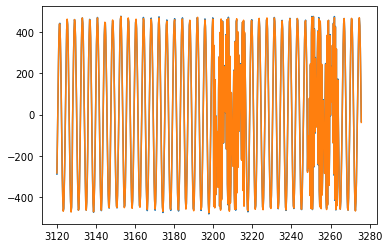

In [44]:
plt.plot(ts[0:624], new_i_lst[0])
plt.plot(ts[0:624], data['i'][0:624])

In [45]:
new_i_lst2 = []
new_q_lst2 = []
fc2 = data.omega.mean();

for i in range(0, len(data2), 624):
    Ai2 = data2.Magnitude[i:i+624].mean()
    Aq2 = data2.Magnitude[i:i+624].mean() 
    ts2 = data2.time_stamp[i:i+624]
    ss2 = s([Ai, Aq, fc, phi], ts)
    ss2[0] += data2['i'][i:i+624]
    ss2[1] += data2['q'][i:i+624]
    

    def fun(theta):
        return (ss2- s(theta, ts2)).flatten()

    theta0 = [0,0,0,0]
    res2 = least_squares(fun, theta0)
    N2 = int(len(res2.fun)/2)
    new_i2 = res2.fun[0:N2]
    new_i_lst2.append(new_i2)
    new_q2 = res2.fun[N2:len(res2.fun)]
    new_q_lst2.append(new_q2)
print('Its finished')

Its finished


In [46]:
from itertools import chain
flatten_i = list(chain.from_iterable(new_i_lst))
flatten_q = list(chain.from_iterable(new_q_lst))
data['new_i'] = flatten_i
data['new_q'] = flatten_q

In [47]:
flatten_i2 = list(chain.from_iterable(new_i_lst2))
flatten_q2 = list(chain.from_iterable(new_q_lst2))
data2['new_i'] = flatten_i2
data2['new_q'] = flatten_q2

In [48]:
info =[]
data_size = len(data)
N = int(data_size/624)
for n in range(N):
    for i in range(36+n*624, 624*(n+1), 8):
        for j in range(i, i+4):
#             print(j)
            info.append({"pkt": n, "Channel": data['channel'][j], "sample_idx": data['sample_idx'][j], 
                         "I": data['i'][j],
                         "Q":data['q'][j],
                         "Magnitude": data['Magnitude'][j],
                         "time_stamp": data['time_stamp'][j], "omega": data['omega'][j], 
                          "new_i": data['new_i'][j], "new_q": data['new_q'][j]})
    info_dec = pd.DataFrame(info)
print('finished', N)

finished 21


In [49]:
info2 =[]
data_size2 = len(data2)
N2 = int(data_size2/624)
for n in range(N2):
    for i in range(36+n*624, 624*(n+1), 8):
        for j in range(i, i+4):
#             print(j)
            info2.append({"pkt": n, "Channel": data2['channel'][j], "sample_idx": data2['sample_idx'][j], 
                         "I": data2['i'][j],
                         "Q":data2['q'][j],
                         "Magnitude": data2['Magnitude'][j],
                         "time_stamp": data2['time_stamp'][j], 
                          "new_i": data2['new_i'][j], "new_q": data2['new_q'][j]})
    info_dec2 = pd.DataFrame(info2)
print('finished', N2)

finished 67


In [50]:
df = info_dec.drop(info_dec[info_dec.sample_idx > 607].index)
df2 = info_dec2.drop(info_dec2[info_dec2.sample_idx > 607].index)

In [51]:
lst_ant1 = []
lst_ant2 = []
lst_ant3 = []

for i in range(0, len(df), 12):    
    lst_ant2.append(df[i:i+4])
    lst_ant1.append(df[i+4:i+8])
    lst_ant3.append(df[i+8:i+12])

In [52]:
lst_ant1_2 = []
lst_ant2_2 = []
lst_ant3_2 = []

for i in range(0, len(df2), 12):    
    lst_ant2_2.append(df2[i:i+4])
    lst_ant1_2.append(df2[i+4:i+8])
    lst_ant3_2.append(df2[i+8:i+12])

In [53]:
df_ant1 = pd.concat(lst_ant1,  ignore_index=True)
df_ant2 = pd.concat(lst_ant2,  ignore_index=True)
df_ant3 = pd.concat(lst_ant3,  ignore_index=True)

In [54]:
df2_ant1 = pd.concat(lst_ant1_2,  ignore_index=True)
df2_ant2 = pd.concat(lst_ant2_2,  ignore_index=True)
df2_ant3 = pd.concat(lst_ant3_2,  ignore_index=True)

### Caluclate the phase difference 

In [55]:
X12 = (df_ant1['I'] + 1j*df_ant1['Q']) * (df_ant2['I'] - 1j*df_ant2['Q'])
X23 = (df_ant2['I'] + 1j*df_ant2['Q']) * (df_ant3['I'] - 1j*df_ant3['Q'])
X13 = (df_ant1['I'] + 1j*df_ant1['Q']) * (df_ant3['I'] - 1j*df_ant3['Q'])
X12_opt = (df_ant1['new_i'] + 1j*df_ant1['new_q']) * (df_ant2['new_i'] - 1j*df_ant2['new_q'])
X23_opt = (df_ant2['new_i'] + 1j*df_ant2['new_q']) * (df_ant3['new_i'] - 1j*df_ant3['new_q'])
X13_opt = (df_ant1['new_i'] + 1j*df_ant1['new_q']) * (df_ant3['new_i'] - 1j*df_ant3['new_q'])


In [56]:
X12_2 = (df2_ant1['I'] + 1j*df2_ant1['Q']) * (df2_ant2['I'] - 1j*df2_ant2['Q'])
X23_2 = (df2_ant2['I'] + 1j*df2_ant2['Q']) * (df2_ant3['I'] - 1j*df2_ant3['Q'])
X13_2 = (df2_ant1['I'] + 1j*df2_ant1['Q']) * (df2_ant3['I'] - 1j*df2_ant3['Q'])
X12_opt_2 = (df2_ant1['new_i'] + 1j*df2_ant1['new_q']) * (df2_ant2['new_i'] - 1j*df2_ant2['new_q'])
X23_opt_2 = (df2_ant2['new_i'] + 1j*df2_ant2['new_q']) * (df2_ant3['new_i'] - 1j*df2_ant3['new_q'])
X13_opt_2 = (df2_ant1['new_i'] + 1j*df2_ant1['new_q']) * (df2_ant3['new_i'] - 1j*df2_ant3['new_q'])


In [57]:
d = {'channel': df_ant1['Channel'],'omega':df_ant1['omega']}
data_fin = pd.DataFrame(data=d)
data_fin['phi12'] = np.angle(X12)
data_fin['phi23'] = np.angle(X23)
data_fin['phi13'] = np.angle(X13)
data_fin['mag12'] = np.abs(X12)
data_fin['mag23'] = np.abs(X23)
data_fin['mag13'] = np.abs(X13)

In [58]:
d2 = {'channel': df2_ant1['Channel']}
data_fin2 = pd.DataFrame(data=d2)
data_fin2['phi12'] = np.angle(X12_2)
data_fin2['phi23'] = np.angle(X23_2)
data_fin2['phi13'] = np.angle(X13_2)
data_fin2['mag12'] = np.abs(X12_2)
data_fin2['mag23'] = np.abs(X23_2)
data_fin2['mag13'] = np.abs(X13_2)

In [59]:
data_fin['phi12_opt'] = np.angle(X12_opt)
data_fin['phi23_opt'] = np.angle(X23_opt)
data_fin['phi13_opt'] = np.angle(X13_opt)
data_fin['mag12_opt'] = np.abs(X12_opt)
data_fin['mag23_opt'] = np.abs(X23_opt)
data_fin['mag13_opt'] = np.abs(X13_opt)

In [60]:
data_fin2['phi12_opt'] = np.angle(X12_opt_2)
data_fin2['phi23_opt'] = np.angle(X23_opt_2)
data_fin2['phi13_opt'] = np.angle(X13_opt_2)
data_fin2['mag12_opt'] = np.abs(X12_opt_2)
data_fin2['mag23_opt'] = np.abs(X23_opt_2)
data_fin2['mag13_opt'] = np.abs(X13_opt_2)

In [61]:
phi_channel = []
for i in range(0, len(data_fin),96):
    phi_channel.append({"channel":data_fin['channel'][i], "omega":data_fin['omega'][i],
                       "ave_phi12": np.average(data_fin['phi12'][i:i+96]),
                       "ave_phi23": np.average(data_fin['phi23'][i:i+96]),
                        "ave_phi13": np.average(data_fin['phi13'][i:i+96]),
                        "ave_phi12_opt": np.average(data_fin['phi12_opt'][i:i+96]),
                       "ave_phi23_opt": np.average(data_fin['phi23_opt'][i:i+96]),
                        "ave_phi13_opt": np.average(data_fin['phi13_opt'][i:i+96]),
                       "ave_mag12": np.average(data_fin['mag12'][i:i+96]),
                       "ave_mag23": np.average(data_fin['mag23'][i:i+96]),
                       "ave_mag13": np.average(data_fin['mag13'][i:i+96]),})
average_perchannel = pd.DataFrame(phi_channel)
print('finished', len(data_fin))

finished 2016


In [62]:
phi_channel2 = []
for i in range(0, len(data_fin2),96):
    phi_channel2.append({"channel":data_fin2['channel'][i],
                       "ave_phi12": np.average(data_fin2['phi12'][i:i+96]),
                       "ave_phi23": np.average(data_fin2['phi23'][i:i+96]),
                        "ave_phi13": np.average(data_fin2['phi13'][i:i+96]),
                        "ave_phi12_opt": np.average(data_fin2['phi12_opt'][i:i+96]),
                       "ave_phi23_opt": np.average(data_fin2['phi23_opt'][i:i+96]),
                        "ave_phi13_opt": np.average(data_fin2['phi13_opt'][i:i+96]),
                       "ave_mag12": np.average(data_fin2['mag12'][i:i+96]),
                       "ave_mag23": np.average(data_fin2['mag23'][i:i+96]),
                       "ave_mag13": np.average(data_fin2['mag13'][i:i+96]),})
average_perchannel2 = pd.DataFrame(phi_channel2)
print('finished', len(data_fin2))

finished 6432


In [63]:
ave_phi12 = np.average(average_perchannel['ave_phi12'])*180/np.pi
ave_phi23 = np.average(average_perchannel['ave_phi23'])*180/np.pi,
ave_phi13 = np.average(average_perchannel['ave_phi13'])*180/np.pi
total_ave = (ave_phi12+ ave_phi23 + ave_phi13)/3

In [64]:
ave_phi12_2 = np.average(average_perchannel2['ave_phi12'])*180/np.pi
ave_phi23_2 = np.average(average_perchannel2['ave_phi23'])*180/np.pi,
ave_phi13_2 = np.average(average_perchannel2['ave_phi13'])*180/np.pi
total_ave_2 = (ave_phi12_2+ ave_phi23_2 + ave_phi13_2)/3

In [65]:
ave_phi12_opt = np.average(average_perchannel['ave_phi12_opt'])*180/np.pi
ave_phi23_opt = np.average(average_perchannel['ave_phi23_opt'])*180/np.pi,
ave_phi13_opt = np.average(average_perchannel['ave_phi13_opt'])*180/np.pi
total_ave_opt = (ave_phi12_opt+ ave_phi23_opt + ave_phi13_opt)/3

In [66]:
ave_phi12_opt2 = np.average(average_perchannel2['ave_phi12_opt'])*180/np.pi
ave_phi23_opt2 = np.average(average_perchannel2['ave_phi23_opt'])*180/np.pi,
ave_phi13_opt2 = np.average(average_perchannel2['ave_phi13_opt'])*180/np.pi
total_ave_opt2 = (ave_phi12_opt2+ ave_phi23_opt2 + ave_phi13_opt2)/3

In [67]:
ave_phi12_opt_rad = np.average(average_perchannel['ave_phi12_opt'])
ave_phi23_opt_rad = np.average(average_perchannel['ave_phi23_opt'])
ave_phi13_opt_rad = np.average(average_perchannel['ave_phi13_opt'])
total_ave_opt_rad = (ave_phi12_opt_rad+ ave_phi23_opt_rad + ave_phi13_opt_rad)/3

In [68]:
print(' Angle per paire', ave_phi12, ave_phi23, ave_phi13, '\n Total average of angle', total_ave)

 Angle per paire -37.69427926374155 (-3.8439569810163317,) 39.7117637552421 
 Total average of angle [-0.60882416]


In [69]:
print(' Angle per paire_ data2 ', ave_phi12_2, ave_phi23_2, ave_phi13_2, '\n Total average of angle', total_ave_2)

 Angle per paire_ data2  85.71321742380373 (54.15654355068848,) -80.09292559267199 
 Total average of angle [19.92561179]


In [34]:
print(' Angle per paire', ave_phi12_opt_rad, ave_phi23_opt_rad, ave_phi13_opt_rad, '\n Total average of angle', total_ave_opt_rad)

 Angle per paire 1.7337001954659932 0.3099852853796119 -0.3052368041300972 
 Total average of angle 0.5794828922385026


In [35]:
print(' Angle per paire OPTIMIZED', ave_phi12_opt, ave_phi23_opt, ave_phi13_opt, '\n Total average of angle_opt', total_ave_opt)

 Angle per paire OPTIMIZED 99.33370414120728 (17.760848563410143,) -17.488780628715944 
 Total average of angle_opt [33.20192403]


array([<AxesSubplot:>], dtype=object)

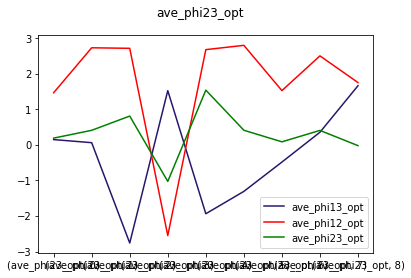

In [36]:
average_perchannel.unstack(level=0)[['ave_phi13_opt']].plot(subplots=True, title="ave_phi13_opt", color= '#28156c', label='ave_phi13_opt', legend=True)
average_perchannel.unstack(level=0)[['ave_phi12_opt']].plot(subplots=True, title="ave_phi12_opt", color= 'r', label='ave_phi12_opt', legend=True)
average_perchannel.unstack(level=0)[['ave_phi23_opt']].plot(subplots=True, title="ave_phi23_opt", color= 'g', label='ave_phi23_opt', legend=True)

array([<AxesSubplot:>], dtype=object)

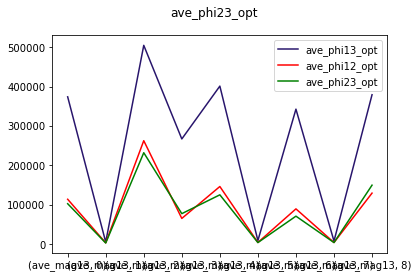

In [37]:
average_perchannel.unstack(level=0)[['ave_mag12']].plot(subplots=True, title="ave_phi13_opt", color= '#28156c', label='ave_phi13_opt', legend=True)
average_perchannel.unstack(level=0)[['ave_mag23']].plot(subplots=True, title="ave_phi12_opt", color= 'r', label='ave_phi12_opt', legend=True)
average_perchannel.unstack(level=0)[['ave_mag13']].plot(subplots=True, title="ave_phi23_opt", color= 'g', label='ave_phi23_opt', legend=True)

### Import the correction file

In [32]:
path_coeff = 'C:/Users/pooneh/Documents/GitHub/AoA_IQsamples/AoA/DoA_Final/3_ANT/3ANT_AoA/datapoints_250cm/3ANT/zerocorrection_coeff_negative.csv'

df_corr = pd.read_csv(path_coeff)
# expected_angel = df_corr.ex_phi12.mean()*180/np.pi

In [33]:
channl = average_perchannel.channel
phi12_corr_ave = []
phi23_corr_ave = []
phi13_corr_ave = []
phi12_corr_ave_opt = []
phi23_corr_ave_opt = []
phi13_corr_ave_opt = []
# phi12_ave = []
for ch in channl:
    g = df_corr[df_corr.channel == ch]
    f = average_perchannel[average_perchannel.channel == ch]
#     print('g is:',g,'and ch is',ch,'\n -------------- f is', f)
    phi12_corr_ave.append(np.average(f.ave_phi12)- np.average(g.phi12_correction))
    phi23_corr_ave.append(np.average(f.ave_phi23)- np.average(g.phi23_correction))
    phi13_corr_ave.append(np.average(f.ave_phi13)- np.average(g.phi13_correction))
    phi12_corr_ave_opt.append(np.average(f.ave_phi12_opt)- np.average(g.phi12_correction))
    phi23_corr_ave_opt.append(np.average(f.ave_phi23_opt)- np.average(g.phi23_correction))
    phi13_corr_ave_opt.append(np.average(f.ave_phi13_opt)- np.average(g.phi13_correction))
#     phi12_ave.append(np.average(g.phi12_correction)*180/np.pi)
#     print(np.average(g.phi12_correction)*180/np.pi)


# print(len(average_perchannel), np.average(phi12_ave))
average_perchannel['corrected_phi12'] = phi12_corr_ave
average_perchannel['corrected_phi23'] = phi23_corr_ave
average_perchannel['corrected_phi13'] = phi13_corr_ave
average_perchannel['corrected_phi12_opt'] = phi12_corr_ave_opt
average_perchannel['corrected_phi23_opt'] = phi23_corr_ave_opt
average_perchannel['corrected_phi13_opt'] = phi13_corr_ave_opt


C:\Users\pooneh\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\pooneh\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\pooneh\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\pooneh\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\pooneh\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\pooneh\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\numpy\core\_method

In [34]:
channl2 = average_perchannel2.channel
phi12_corr_ave2 = []
phi23_corr_ave2 = []
phi13_corr_ave2 = []
phi12_corr_ave_opt2 = []
phi23_corr_ave_opt2 = []
phi13_corr_ave_opt2 = []
# phi12_ave = []
for ch in channl2:
    g = df_corr[df_corr.channel == ch]
    f = average_perchannel2[average_perchannel2.channel == ch]
#     print('g is:',g,'and ch is',ch,'\n -------------- f is', f)
    phi12_corr_ave2.append(np.average(f.ave_phi12)- np.average(g.phi12_correction))
    phi23_corr_ave2.append(np.average(f.ave_phi23)- np.average(g.phi23_correction))
    phi13_corr_ave2.append(np.average(f.ave_phi13)- np.average(g.phi13_correction))
    phi12_corr_ave_opt2.append(np.average(f.ave_phi12_opt)- np.average(g.phi12_correction))
    phi23_corr_ave_opt2.append(np.average(f.ave_phi23_opt)- np.average(g.phi23_correction))
    phi13_corr_ave_opt2.append(np.average(f.ave_phi13_opt)- np.average(g.phi13_correction))
#     phi12_ave.append(np.average(g.phi12_correction)*180/np.pi)
#     print(np.average(g.phi12_correction)*180/np.pi)


# print(len(average_perchannel), np.average(phi12_ave))
average_perchannel2['corrected_phi12'] = phi12_corr_ave2
average_perchannel2['corrected_phi23'] = phi23_corr_ave2
average_perchannel2['corrected_phi13'] = phi13_corr_ave2
average_perchannel2['corrected_phi12_opt'] = phi12_corr_ave_opt2
average_perchannel2['corrected_phi23_opt'] = phi23_corr_ave_opt2
average_perchannel2['corrected_phi13_opt'] = phi13_corr_ave_opt2


In [35]:
average_perchannel = average_perchannel.dropna()

In [36]:
average_perchannel2 = average_perchannel2.dropna()

In [37]:
len(average_perchannel2), len(average_perchannel),

(60, 70)

In [38]:
np.unique(average_perchannel2.channel), np.unique(average_perchannel.channel)

(array([ 0,  1,  2,  3,  4,  5,  8,  9, 11, 12, 14, 16, 18, 19, 21, 23, 24,
        25, 26, 27, 30, 31, 32, 33, 34], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35],
       dtype=int64))

In [42]:
len(average_perchannel[0:60])

60

## USING NNL

theta = arcsin/cos((land/(2.pi*dij)) * deltaphi(ij)) 

In [37]:
# defining the target angle 
real_phi= 90
cos = np.cos(np.deg2rad(real_phi))
landa = 2.9e8/(average_perchannel.omega*1e6)
d12 = 3.5e-2
ex_phi12 = (cos* 2*np.pi*d12)/landa
expected_angel = ex_phi12.mean()*180/np.pi
expected_angel

6.49155461933101e-15

In [58]:
target = average_perchannel[0:60].corrected_phi12_opt
input_feature = average_perchannel2.ave_phi12_opt
weights = np.random.rand(len(input_feature),1)
baias = 0.3 
lr = 0.05

In [59]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [60]:
def sigmoid_der(x):
    return sigmoid(x)*(1-sigmoid(x))

In [61]:
# Running the code 1000 times:
for epoch in range(1000):
    inputs = input_feature
    
    # Feed_forward input:
    in_o = np.dot(inputs, weights) + baias
    
    # Feed_forward output:
    out_o = sigmoid(in_o) + ex_phi12.mean()
    
    #Backpropagation
    # Calculating error
    error = out_o - target
    
    # Going with the formula:
    x = error.sum()
    print(x)
    
    # Calculating derivatives:
    derror_douto = error
    douto_dino = sigmoid_der(out_o)
    
    # Multiplying individual derivations:
    derive = derror_douto * douto_dino
    
    # Multiplying with the 3rd individual derivative:
    # Finding the transpose of input_features:
    inputs = input_feature.T 
    derive_final = np.dot(inputs, derive)
    
    # updating the weights values:
    weights -= lr* derive_final
    
    # Updating the bais weight value:
    for i in derive:
        baias -= lr*i 

-24.180272195790057
18.618453034348903
-24.180272195790057
35.819727804209954
-24.18026842007129
35.819727804209954
35.43997067547612
-24.180272195790057
35.81972780409917
-24.180272195789694
35.819727804209954
-24.17937546737076
35.819727804209954
35.81811270696325
-24.180272195790057
35.81972780420929
-24.180272195728477
35.819727804209954
-24.027024045744113
35.819727804209954
35.819710040516036
-24.180272195790057
35.81972780420993
-24.180272190198288
35.819727804209954
-12.861364641247189
35.819727804209954
-24.18027218809902
35.819727804209954
-9.641673824094475
35.81972780404377
-24.18027219578982
35.819727804209954
-24.1796744662345
35.819727804209954
35.8173078310124
-24.180272195790057
35.81972780420897
-24.180272195748927
35.819727804209954
-24.077838667706047
35.819727804209954
35.81970626889349
-24.180272195790057
35.81972780420993
-24.1802721911776
35.819727804209954
-14.52468178931972
35.819727804209954
-24.18027012425818
35.819727804209954
35.131146142970174
-24.1802721

-24.180272195262052
35.819727804209954
-22.89126534550445
35.819727804209954
35.819505438720334
-24.180272195790057
35.81972780420985
-24.180272195343278
35.819727804209954
-23.085960369880148
35.819727804209954
35.81960920317781
-24.180272195790057
35.81972780420991
-24.18027219495247
35.819727804209954
-22.1609363451765
35.819727804209954
35.8170159308271
-24.180272195790057
35.81972780420887
-24.180272195753354
35.819727804209954
-24.088825467618165
35.819727804209954
35.81970475437826
-24.180272195790057
35.81972780420993
-24.18027219148066
35.819727804209954
-15.062695681479793
35.819727804209954
-24.180259113943624
35.819727804209954
35.7096212713038
-24.180272195790057
35.819727804169666
-24.180272195789072
35.819727804209954
-24.17780569964737
35.819727804209954
35.81913676853302
-24.180272195790057
35.8197278042097
-24.18027219562191
35.819727804209954
-23.763694610339677
35.819727804209954
35.81970842311862
-24.180272195790057
35.81972780420993
-24.18027219066493
35.819727804

In [62]:
print(weights), print(baias)

[[-0.94543461]
 [-0.15958665]
 [-0.26532447]
 [-0.50115123]
 [-0.75399753]
 [-0.70246088]
 [-0.41217828]
 [-0.86359239]
 [-0.67989596]
 [-0.86645348]
 [-0.63973125]
 [-0.83719376]
 [-0.50587474]
 [-0.29977971]
 [-0.24118387]
 [-0.06947682]
 [ 0.00650437]
 [-0.7658963 ]
 [-0.4546812 ]
 [-0.78195978]
 [-0.0576095 ]
 [-0.25917759]
 [-0.06738327]
 [-0.82892361]
 [-0.37236022]
 [-0.73151154]
 [-0.05638921]
 [-0.06747398]
 [-0.83636922]
 [-0.05947306]
 [-0.7555972 ]
 [-0.40717897]
 [-0.47023125]
 [-0.04319136]
 [-0.35351049]
 [-0.88660289]
 [-0.426199  ]
 [-0.09076813]
 [-0.69226963]
 [-0.39967514]
 [ 0.03407487]
 [-0.05447281]
 [-0.06947546]
 [-0.91410123]
 [-0.52699463]
 [-0.67227239]
 [-0.79720481]
 [-0.56492727]
 [-0.17021968]
 [-0.09978475]
 [-0.19431486]
 [-0.27658526]
 [-0.56198561]
 [-0.37901217]
 [-0.49556147]
 [-0.14394061]
 [-0.27034313]
 [-0.95878924]
 [-0.28667492]
 [-0.34228721]]
1.442222745167532


(None, None)

In [38]:
# Now that the mode is trained, see how does it predict

In [39]:
result1 = np.dot(average_perchannel.ave_phi23_opt, weights) + baias

In [40]:
result2 = sigmoid(result1)

In [44]:
print(result2), 

[1.]


(None, 70, 70)

In [51]:
len(weights), len(average_perchannel), baias, weights[0], average_perchannel.ave_phi23_opt[12]

(70, 70, 484.7850305534183, array([1381.71163353]), 0.33245249040139513)

In [49]:
ave_phi23_arr = np.asarray(average_perchannel[0:60].ave_phi23_opt)

In [57]:
for i in range(len(ave_phi23_arr)):
    result1 = np.dot(ave_phi23_arr[i], weights[i]) + baias
    result2 = sigmoid(result1)+ ex_phi12.mean()
    print(result1,result2)

[67.21981562] [2.30749066]
[168.62204734] [2.30749066]
[109.62517169] [2.30749066]
[199.64292412] [2.30749066]
[54.03966522] [2.30749066]
[191.87002375] [2.30749066]
[-5.22606451] [1.31283656]
[30.37668203] [2.30749066]
[196.08727906] [2.30749066]
[97.80663566] [2.30749066]
[58.18569983] [2.30749066]
[160.02374143] [2.30749066]
[59.66937568] [2.30749066]
[188.84367233] [2.30749066]
[67.6005682] [2.30749066]
[133.24913931] [2.30749066]
[124.26049482] [2.30749066]
[257.22104838] [2.30749066]
[107.7545037] [2.30749066]
[-11.67224208] [1.30749918]
[109.50040687] [2.30749066]
[-3.05537729] [1.35247655]
[88.56062346] [2.30749066]
[55.63655043] [2.30749066]
[143.67077051] [2.30749066]
[44.87235932] [2.30749066]
[115.48196224] [2.30749066]
[194.74554753] [2.30749066]
[84.21626902] [2.30749066]
[123.23048797] [2.30749066]
[54.24283331] [2.30749066]
[146.92847723] [2.30749066]
[15.18796486] [2.3074904]
[144.43238596] [2.30749066]
[38.16620857] [2.30749066]
[169.27578179] [2.30749066]
[87.1079654

In [52]:
error.mean()*180/np.pi

-40.70837600155786

In [53]:
derive_final

21.654559087556287